In [189]:
library(tidyverse)
library(cowplot)
library(VennDiagram)
library(gridExtra)

# Read files

In [246]:
pgnames_mxout <- function(path){
    PG_report <- read.table(
        path,
        header=T,
        sep="\t",
        stringsAsFactors = F)
    
    # remove decoy matches and matches to contaminant
    PG_report <- PG_report[!PG_report$Reverse=="+",]
    PG_report <- PG_report[!PG_report$Potential.contaminant=="+",]
    # if the PG_report$Only.identified.by.site is not all NA and contains "+" values - remove this rows
    if(!all(is.na(PG_report$Only.identified.by.site))) {
        # # Only.identified.by.site - exclude proteins that were only identified by a modification site
        PG_report <- PG_report[!PG_report$Only.identified.by.site=="+",]
    }

        # filter out the rows with 1 or 0 in Peptide counts (razor+unique)
    PG_report <- PG_report[PG_report$Gene.names != '',]


    df_names <- PG_report %>%
        select(Protein.IDs, Majority.protein.IDs, Gene.names, Peptide.IDs, Peptide.is.razor, Fasta.headers)

    return(df_names)    
}

In [247]:
list_of_outputs <- list(
    "Center1" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center1.txt",
    "Center2" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center2.txt",
    "Center3" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center3.txt"
)

combined_pg_intensities <- list()

for(center in names(list_of_outputs)) {
    center_folder <- ifelse(center == "Center1", "center_one", ifelse(center == "Center2", "center_two", "center_three"))
    pg_intensities <- pgnames_mxout(list_of_outputs[[center]])
    # add it to the list using the center name as the key
    combined_pg_intensities <- c(combined_pg_intensities, list(pg_intensities))
    
}
# add names to the list
names(combined_pg_intensities) <- names(list_of_outputs)
# head(combined_pg_intensities)
colnames(combined_pg_intensities[[1]])

[1] "Protein.IDs"          "Majority.protein.IDs" "Gene.names"          
[4] "Peptide.IDs"          "Peptide.is.razor"     "Fasta.headers"

In [212]:
# intersect the protein names from all centers
intersect(
    combined_pg_intensities[["Center1"]]$Protein.IDs,
    combined_pg_intensities[["Center3"]]$Protein.IDs
) %>% length()

intersect(
    combined_pg_intensities[["Center1"]]$Protein.IDs,
    combined_pg_intensities[["Center2"]]$Protein.IDs
) %>% length()


intersect(
    combined_pg_intensities[["Center2"]]$Protein.IDs,
    combined_pg_intensities[["Center3"]]$Protein.IDs
) %>% length()

# intersect the gene names from all centers
intersect(
    combined_pg_intensities[["Center1"]]$Protein.IDs,
    combined_pg_intensities[["Center3"]]$Protein.IDs
) %>% intersect(combined_pg_intensities[["Center2"]]$Protein.IDs) %>% length()

[1] 274

[1] 272

[1] 279

[1] 224

In [213]:
# same for gene names
intersect(
    combined_pg_intensities[["Center1"]]$Gene.names,
    combined_pg_intensities[["Center3"]]$Gene.names
) %>% intersect(combined_pg_intensities[["Center2"]]$Gene.names) %>% length()

[1] 353

In [214]:
# same for gene names
intersect(
    combined_pg_intensities[["Center1"]]$Majority.protein.IDs,
    combined_pg_intensities[["Center3"]]$Majority.protein.IDs
) %>% intersect(combined_pg_intensities[["Center2"]]$Majority.protein.IDs) %>% length()

[1] 255

In [215]:
# intersect the gene names from all centers
intersect(
    combined_pg_intensities[["Center1"]]$Protein.IDs,
    combined_pg_intensities[["Center3"]]$Protein.IDs
) %>% intersect(combined_pg_intensities[["Center2"]]$Protein.IDs) %>% length()

[1] 224

## PG.IDs

In [216]:
pg_one <- unique(unlist(strsplit(combined_pg_intensities[["Center1"]]$Protein.IDs, ";")))
length(pg_one)

pg_two <- unique(unlist(strsplit(combined_pg_intensities[["Center2"]]$Protein.IDs, ";")))
length(pg_two)

pg_three <- unique(unlist(strsplit(combined_pg_intensities[["Center3"]]$Protein.IDs, ";")))
length(pg_three)

common_proteins <- intersect(pg_one, pg_two) %>% intersect(pg_three) 

[1] 2125

[1] 2240

[1] 1814

[1] 1508

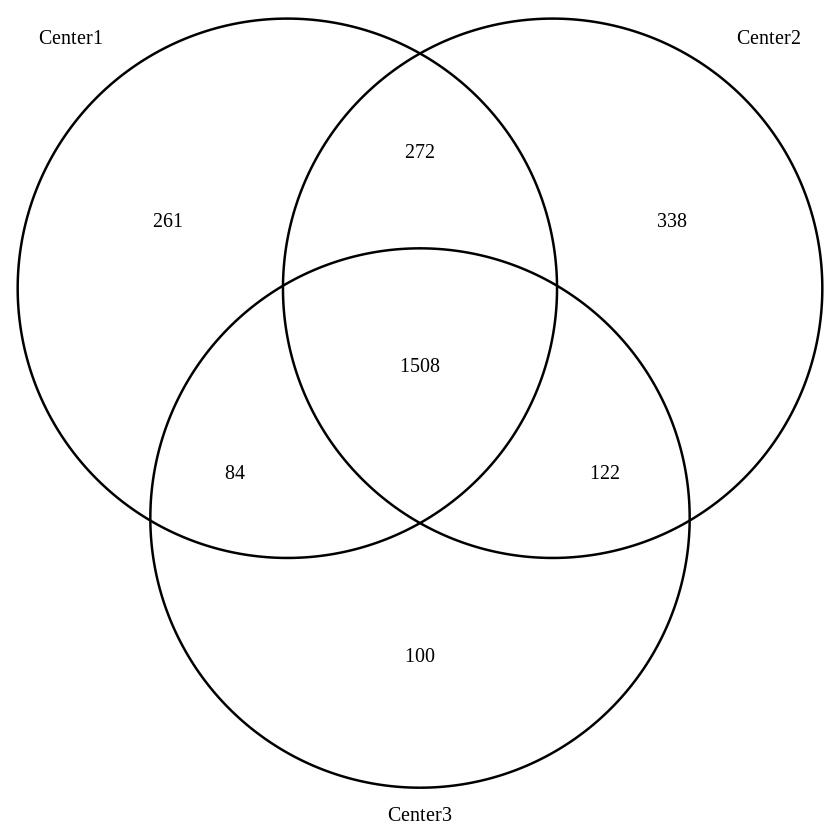

In [217]:
intersect(pg_one, pg_two) %>% intersect(pg_three) %>% length()

# plot venn  diagram
grid.newpage()

venn_plot <- venn.diagram(
    x = list(
        "Center1" = pg_one,
        "Center2" = pg_two,
        "Center3" = pg_three
    ),
    lwd = 2,
    filename = NULL)

grid.draw(venn_plot)

In [218]:
# for each df in combined_pg_intensities, calculate the new column
# that contains the number of proteins in the intersection devided by the total number of proteins in the PG for each row

for(center in names(combined_pg_intensities)) {
    pg <- combined_pg_intensities[[center]]
    pg$Protein.IDs <- as.character(pg$Protein.IDs)
    pg$Protein.IDs <- strsplit(pg$Protein.IDs, ";")
    pg$Protein.IDs.common  <- sapply(pg$Protein.IDs, function(x) length(intersect(x, common_proteins))/length(x))
    combined_pg_intensities[[center]] <- pg
}

In [219]:
# print lenght of the Protein.IDs.common where value is equal 0
combined_pg_intensities[["Center1"]] %>% filter(Protein.IDs.common == 0) %>% nrow()
combined_pg_intensities[["Center2"]] %>% filter(Protein.IDs.common == 0) %>% nrow()
combined_pg_intensities[["Center3"]] %>% filter(Protein.IDs.common == 0) %>% nrow()

# Make a % for it
combined_pg_intensities[["Center1"]] %>% filter(Protein.IDs.common == 0) %>% nrow() / nrow(combined_pg_intensities[["Center1"]])
combined_pg_intensities[["Center2"]] %>% filter(Protein.IDs.common == 0) %>% nrow() / nrow(combined_pg_intensities[["Center2"]])
combined_pg_intensities[["Center3"]] %>% filter(Protein.IDs.common == 0) %>% nrow() / nrow(combined_pg_intensities[["Center3"]])

[1] 88

[1] 117

[1] 53

[1] 0.18107

[1] 0.2267442

[1] 0.1196388

Warning message in plot_grid(p1, p2, p3, labels = "AUTO", cols = 1):
“Argument 'cols' is deprecated. Use 'ncol' instead.”


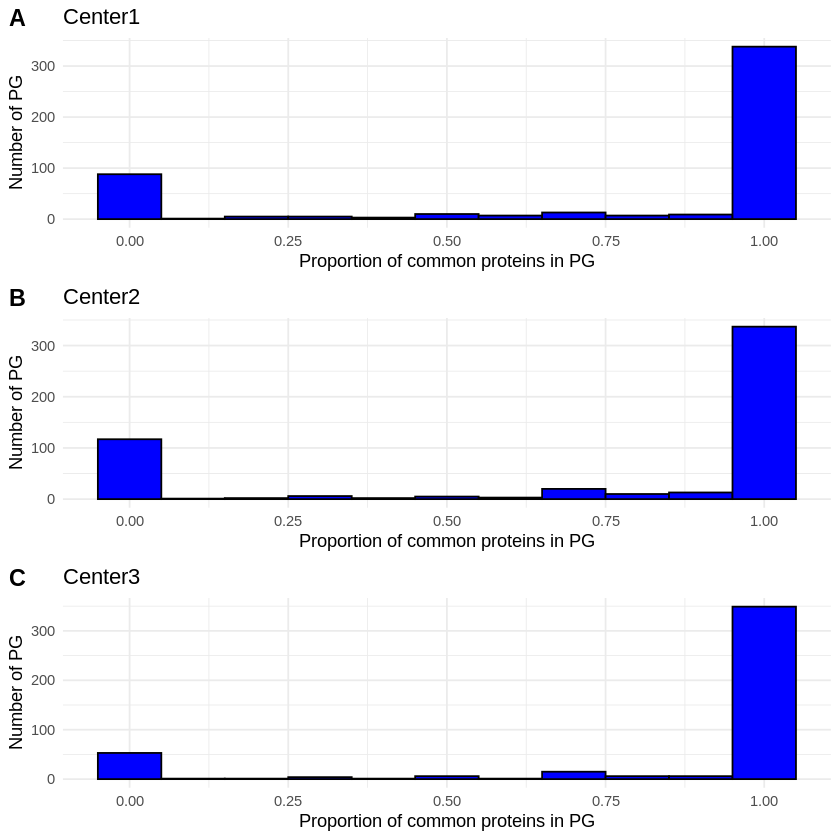

In [220]:
# create three plots with distributions of the common proteins in each center

p1 <- ggplot(combined_pg_intensities[["Center1"]], aes(x=Protein.IDs.common)) +
    geom_histogram(binwidth=0.1, fill="blue", color="black") +
    labs(title="Center1", x="Proportion of common proteins in PG", y="Number of PG") +
    theme_minimal()

p2 <- ggplot(combined_pg_intensities[["Center2"]], aes(x=Protein.IDs.common)) +
    geom_histogram(binwidth=0.1, fill="blue", color="black") +
    labs(title="Center2", x="Proportion of common proteins in PG", y="Number of PG") +
    theme_minimal()

p3 <- ggplot(combined_pg_intensities[["Center3"]], aes(x=Protein.IDs.common)) +
    geom_histogram(binwidth=0.1, fill="blue", color="black") +
    labs(title="Center3", x="Proportion of common proteins in PG", y="Number of PG") +
    theme_minimal()

plot_grid(p1, p2, p3, labels = "AUTO", cols = 1)

Warning message in plot_grid(p1, p2, p3, labels = "AUTO", cols = 1):
“Argument 'cols' is deprecated. Use 'ncol' instead.”


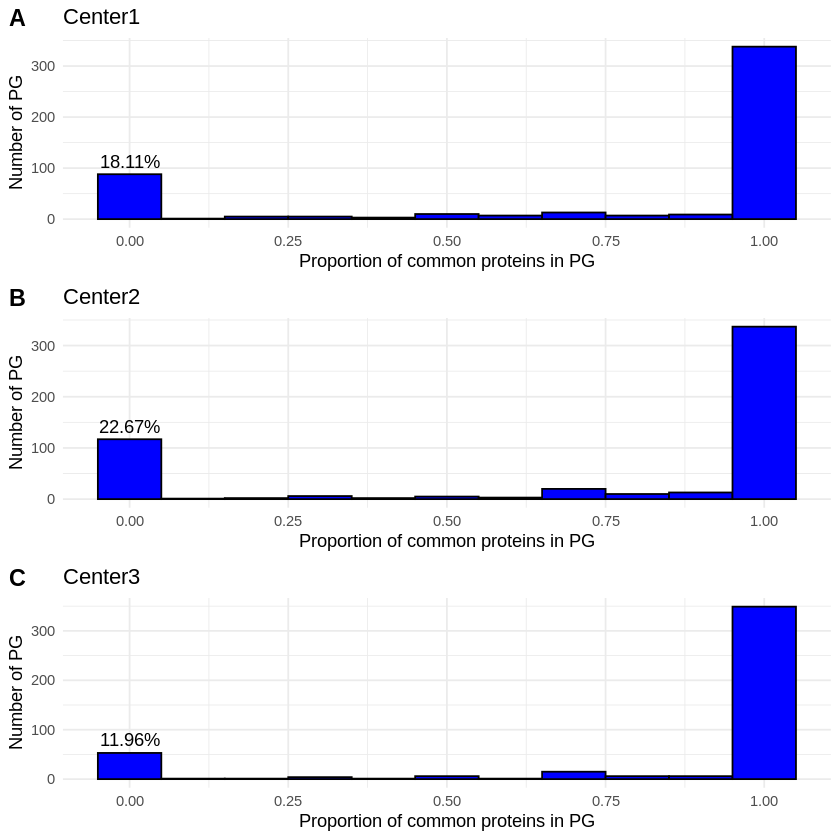

In [221]:
# Calculate the percentages
percent_c1 <- combined_pg_intensities[["Center1"]] %>% 
  filter(Protein.IDs.common == 0) %>% 
  nrow() / nrow(combined_pg_intensities[["Center1"]]) * 100

percent_c2 <- combined_pg_intensities[["Center2"]] %>% 
  filter(Protein.IDs.common == 0) %>% 
  nrow() / nrow(combined_pg_intensities[["Center2"]]) * 100

percent_c3 <- combined_pg_intensities[["Center3"]] %>% 
  filter(Protein.IDs.common == 0) %>% 
  nrow() / nrow(combined_pg_intensities[["Center3"]]) * 100

# Create plots with annotations for the 0% bars
p1 <- ggplot(combined_pg_intensities[["Center1"]], aes(x=Protein.IDs.common)) +
    geom_histogram(binwidth=0.1, fill="blue", color="black") +
    labs(title="Center1", x="Proportion of common proteins in PG", y="Number of PG") +
    geom_text(aes(label=paste0(round(percent_c1, 2), "%"), y=..count..), stat="count", vjust=-0.5, data=subset(combined_pg_intensities[["Center1"]], Protein.IDs.common == 0)) +
    theme_minimal()

p2 <- ggplot(combined_pg_intensities[["Center2"]], aes(x=Protein.IDs.common)) +
    geom_histogram(binwidth=0.1, fill="blue", color="black") +
    labs(title="Center2", x="Proportion of common proteins in PG", y="Number of PG") +
    geom_text(aes(label=paste0(round(percent_c2, 2), "%"), y=..count..), stat="count", vjust=-0.5, data=subset(combined_pg_intensities[["Center2"]], Protein.IDs.common == 0)) +
    theme_minimal()

p3 <- ggplot(combined_pg_intensities[["Center3"]], aes(x=Protein.IDs.common)) +
    geom_histogram(binwidth=0.1, fill="blue", color="black") +
    labs(title="Center3", x="Proportion of common proteins in PG", y="Number of PG") +
    geom_text(aes(label=paste0(round(percent_c3, 2), "%"), y=..count..), stat="count", vjust=-0.5, data=subset(combined_pg_intensities[["Center3"]], Protein.IDs.common == 0)) +
    theme_minimal()

# Combine the plots
plot_grid(p1, p2, p3, labels = "AUTO", cols = 1)

In [222]:
# print lenght of the Protein.IDs.common where value is equal 0
combined_pg_intensities[["Center1"]] %>% filter(Protein.IDs.common == 0) %>% nrow()
combined_pg_intensities[["Center2"]] %>% filter(Protein.IDs.common == 0) %>% nrow()
combined_pg_intensities[["Center3"]] %>% filter(Protein.IDs.common == 0) %>% nrow()

# Make a % for it
combined_pg_intensities[["Center1"]] %>% filter(Protein.IDs.common == 0) %>% nrow() / nrow(combined_pg_intensities[["Center1"]])
combined_pg_intensities[["Center2"]] %>% filter(Protein.IDs.common == 0) %>% nrow() / nrow(combined_pg_intensities[["Center2"]])
combined_pg_intensities[["Center3"]] %>% filter(Protein.IDs.common == 0) %>% nrow() / nrow(combined_pg_intensities[["Center3"]])

[1] 88

[1] 117

[1] 53

[1] 0.18107

[1] 0.2267442

[1] 0.1196388

In [223]:
nrow(combined_pg_intensities[["Center1"]])
nrow(combined_pg_intensities[["Center1"]]) - combined_pg_intensities[["Center1"]] %>% filter(Protein.IDs.common == 0) %>% nrow()

nrow(combined_pg_intensities[["Center2"]])
nrow(combined_pg_intensities[["Center2"]]) - combined_pg_intensities[["Center2"]] %>% filter(Protein.IDs.common == 0) %>% nrow()

nrow(combined_pg_intensities[["Center3"]])
nrow(combined_pg_intensities[["Center3"]]) - combined_pg_intensities[["Center3"]] %>% filter(Protein.IDs.common == 0) %>% nrow()

[1] 486

[1] 398

[1] 516

[1] 399

[1] 443

[1] 390

## Majority.PG.ID

In [53]:
pg_one <- unique(unlist(strsplit(combined_pg_intensities[["Center1"]]$Majority.protein.IDs, ";")))
length(pg_one)

pg_two <- unique(unlist(strsplit(combined_pg_intensities[["Center2"]]$Majority.protein.IDs, ";")))
length(pg_two)

pg_three <- unique(unlist(strsplit(combined_pg_intensities[["Center3"]]$Majority.protein.IDs, ";")))
length(pg_three)

# common_proteins <- intersect(pg_one, pg_two) %>% intersect(pg_three) 
# length(common_proteins)

[1] 1545

[1] 1570

[1] 1265

[1] 973

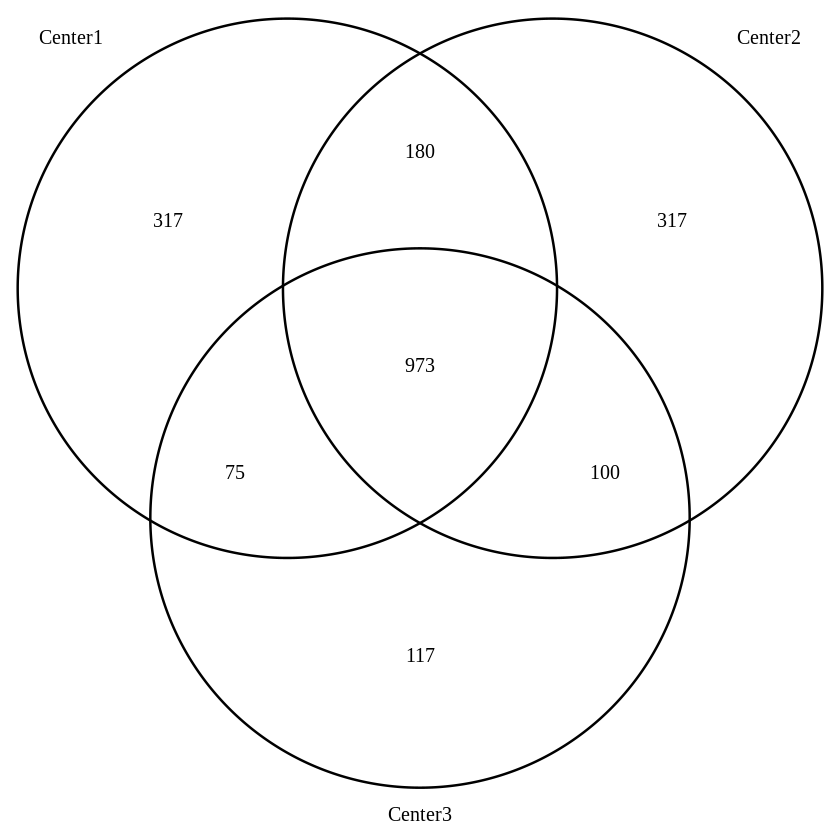

In [ ]:
intersect(pg_one, pg_two) %>% intersect(pg_three) %>% length()

# plot venn  diagram
grid.newpage()

venn_plot <- venn.diagram(
    x = list(
        "Center1" = pg_one,
        "Center2" = pg_two,
        "Center3" = pg_three
    ),
    lwd = 2,
    filename = NULL)

grid.draw(venn_plot)

In [18]:
# for each df in combined_pg_intensities, calculate the new column
# that contains the number of proteins in the intersection devided by the total number of proteins in the PG for each row

for(center in names(combined_pg_intensities)) {
    pg <- combined_pg_intensities[[center]]
    pg$Majority.protein.IDs <- as.character(pg$Majority.protein.IDs)
    pg$Majority.protein.IDs <- strsplit(pg$Majority.protein.IDs, ";")
    pg$Majority.P.IDs.common  <- sapply(pg$Majority.protein.IDs, function(x) length(intersect(x, common_proteins))/length(x))
    combined_pg_intensities[[center]] <- pg
}

Warning message in plot_grid(p1, p2, p3, labels = "AUTO", cols = 1):
“Argument 'cols' is deprecated. Use 'ncol' instead.”


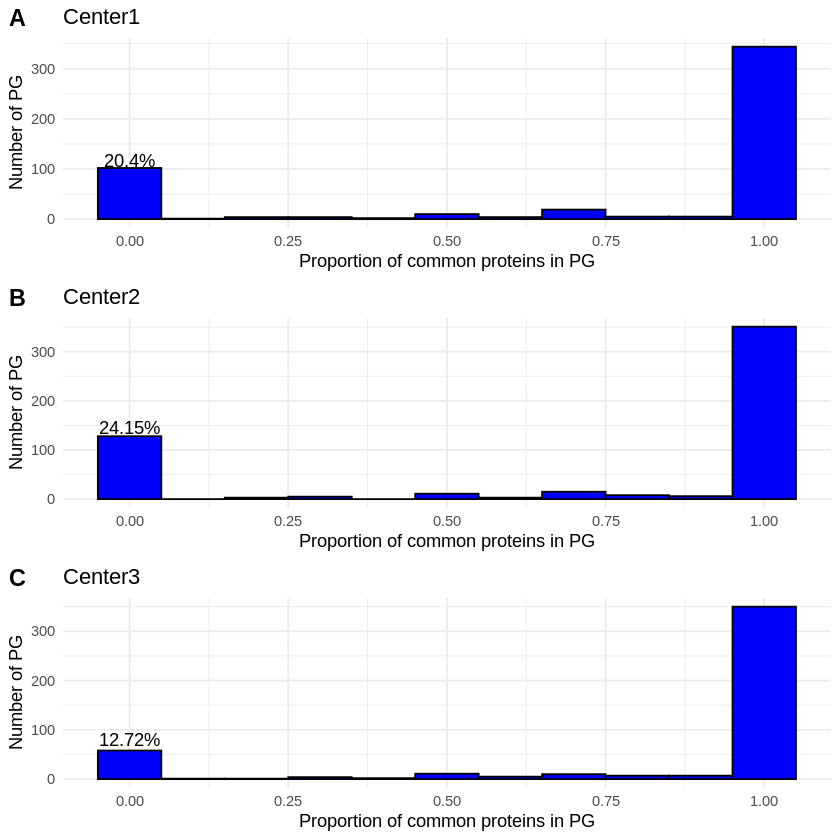

In [19]:
# Calculate the percentages
percent_c1 <- combined_pg_intensities[["Center1"]] %>% 
  filter(Majority.P.IDs.common == 0) %>% 
  nrow() / nrow(combined_pg_intensities[["Center1"]]) * 100

percent_c2 <- combined_pg_intensities[["Center2"]] %>% 
  filter(Majority.P.IDs.common == 0) %>% 
  nrow() / nrow(combined_pg_intensities[["Center2"]]) * 100

percent_c3 <- combined_pg_intensities[["Center3"]] %>% 
  filter(Majority.P.IDs.common == 0) %>% 
  nrow() / nrow(combined_pg_intensities[["Center3"]]) * 100

# Create plots with annotations for the 0% bars
p1 <- ggplot(combined_pg_intensities[["Center1"]], aes(x=Majority.P.IDs.common)) +
    geom_histogram(binwidth=0.1, fill="blue", color="black") +
    labs(title="Center1", x="Proportion of common proteins in PG", y="Number of PG") +
    geom_text(aes(label=paste0(round(percent_c1, 2), "%"), y=..count..), stat="count", vjust=-0.5, data=subset(combined_pg_intensities[["Center1"]], Protein.IDs.common == 0)) +
    theme_minimal()

p2 <- ggplot(combined_pg_intensities[["Center2"]], aes(x=Majority.P.IDs.common)) +
    geom_histogram(binwidth=0.1, fill="blue", color="black") +
    labs(title="Center2", x="Proportion of common proteins in PG", y="Number of PG") +
    geom_text(aes(label=paste0(round(percent_c2, 2), "%"), y=..count..), stat="count", vjust=-0.5, data=subset(combined_pg_intensities[["Center2"]], Protein.IDs.common == 0)) +
    theme_minimal()

p3 <- ggplot(combined_pg_intensities[["Center3"]], aes(x=Majority.P.IDs.common)) +
    geom_histogram(binwidth=0.1, fill="blue", color="black") +
    labs(title="Center3", x="Proportion of common proteins in PG", y="Number of PG") +
    geom_text(aes(label=paste0(round(percent_c3, 2), "%"), y=..count..), stat="count", vjust=-0.5, data=subset(combined_pg_intensities[["Center3"]], Protein.IDs.common == 0)) +
    theme_minimal()

# Combine the plots
plot_grid(p1, p2, p3, labels = "AUTO", cols = 1)

In [20]:
nrow(combined_pg_intensities[["Center1"]])
nrow(combined_pg_intensities[["Center1"]]) - combined_pg_intensities[["Center1"]] %>% filter(Majority.P.IDs.common == 0) %>% nrow()

nrow(combined_pg_intensities[["Center2"]])
nrow(combined_pg_intensities[["Center2"]]) - combined_pg_intensities[["Center2"]] %>% filter(Majority.P.IDs.common == 0) %>% nrow()

nrow(combined_pg_intensities[["Center3"]])
nrow(combined_pg_intensities[["Center3"]]) - combined_pg_intensities[["Center3"]] %>% filter(Majority.P.IDs.common == 0) %>% nrow()

[1] 500

[1] 398

[1] 530

[1] 402

[1] 456

[1] 398

# keep the PG if the 50% of the isoforms are inside

In [224]:
combined_pg_intensities_filteres <- combined_pg_intensities

for(center in names(combined_pg_intensities)) {
    pg <- combined_pg_intensities[[center]]
    print(center)
    print(nrow(pg))
    # pg <- pg %>% filter(Protein.IDs.common >= 0.5)
    # Create a new column that contain only proteins frim Proteins.IDs that are common
    pg$Protein.IDs.new_list <- sapply(pg$Protein.IDs, function(x) intersect(x, common_proteins)) 
    pg$Protein.IDs.new <- pg$Protein.IDs.new_list %>%
        sapply(function(x) paste(x, collapse = ";")) %>% as.character()
    # remove rows where the new column is empty
    pg <- pg %>% filter(pg$Protein.IDs.new != "")
    combined_pg_intensities_filteres[[center]] <- pg
    print(nrow(pg))
}

[1] "Center1"
[1] 486
[1] 398
[1] "Center2"
[1] 516
[1] 399
[1] "Center3"
[1] 443
[1] 390


[1] 398

[1] 399

[1] 390

[1] 275

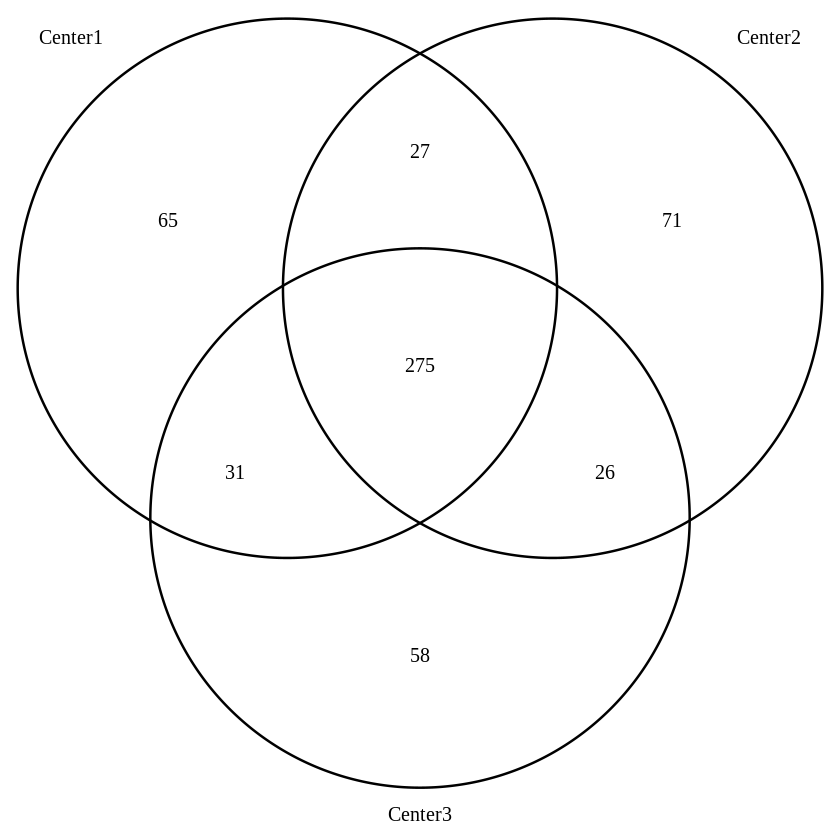

In [225]:
pg_one <- unique(combined_pg_intensities_filteres[["Center1"]]$Protein.IDs.new)
length(pg_one)

pg_two <- unique(combined_pg_intensities_filteres[["Center2"]]$Protein.IDs.new)
length(pg_two)

pg_three <- unique(combined_pg_intensities_filteres[["Center3"]]$Protein.IDs.new)
length(pg_three)

intersect(pg_one, pg_two) %>% intersect(pg_three) %>% length()

# plot venn  diagram
grid.newpage()

venn_plot <- venn.diagram(
    x = list(
        "Center1" = pg_one,
        "Center2" = pg_two,
        "Center3" = pg_three
    ),
    lwd = 2,
    filename = NULL)

grid.draw(venn_plot)

In [226]:
pg_one <- combined_pg_intensities_filteres[["Center1"]]$Protein.IDs.new
length(pg_one)

pg_two <- combined_pg_intensities_filteres[["Center2"]]$Protein.IDs.new
length(pg_two)

pg_three <- combined_pg_intensities_filteres[["Center3"]]$Protein.IDs.new
length(pg_three)

# combine all into one list
joint_proteins <- c(pg_one, pg_two, pg_three) %>% unique()
length(joint_proteins)


[1] 398

[1] 399

[1] 390

[1] 553

In [227]:
# Initialize the new data frame
result_df <- setNames(data.frame(matrix(ncol = 3, nrow = length(joint_proteins))), c("center1", "center2", "center3"))
rownames(result_df) <- joint_proteins

# Function to check intersection
check_intersection <- function(row_name, df) {
  spl_row_name <- unlist(strsplit(row_name, ";"))
  matches <- sapply(df$Protein.IDs.new, function(x) {
    length(intersect(unlist(strsplit(x, ";")), spl_row_name)) > 0
  })
  paste(df$Protein.IDs.new[matches], collapse = " | ")
}

# Fill the result data frame
for(i in 1:nrow(result_df)) {
  row_name <- rownames(result_df)[i]
  result_df[i, "center1"] <- check_intersection(row_name, combined_pg_intensities_filteres[["Center1"]])
  result_df[i, "center2"] <- check_intersection(row_name, combined_pg_intensities_filteres[["Center2"]])
  result_df[i, "center3"] <- check_intersection(row_name, combined_pg_intensities_filteres[["Center3"]])
}

In [229]:
# print rows from result_df where any of the columns contains " | " or empty string
result_df %>% filter(grepl(" | ", center1) | grepl(" | ", center2) | grepl(" | ", center3) | center1 == "" | center2 == "" | center3 == "")

,center1,center2,center3
,<chr>,<chr>,<chr>
A0A075B6P5;A0A087WW87;P01615;P01614;A2NJV5;A0A0A0MRZ7;A0A075B6S6;A0A075B6S2,A0A075B6P5;A0A087WW87;P01615;P01614;A2NJV5;A0A0A0MRZ7;A0A075B6S6;A0A075B6S2,A0A075B6P5;A0A087WW87;P01615;P01614 | A2NJV5;A0A075B6S2 | A0A0A0MRZ7;A0A075B6S6,A0A075B6P5;A0A087WW87;P01615;P01614;A0A0A0MRZ7;A0A075B6S6 | A2NJV5;A0A075B6S2
P0DP08;P0DP06;A0A0C4DH41;P01825;P06331;P01824;A0A0J9YWU9;A0A087WW49;A0A075B6R2;P0DP07;A0A087WSY4,P0DP08;P0DP06;A0A0C4DH41;P01825;P06331;P01824;A0A0J9YWU9;A0A087WW49;A0A075B6R2;P0DP07;A0A087WSY4,A0A075B6R2;A0A087WW49 | P0DP08;P0DP06;A0A0C4DH41;P01825;P06331;P01824;A0A0J9YWU9;P0DP07;A0A087WSY4,P0DP08;P0DP06;A0A0C4DH41;P01825;P06331;P01824;A0A0J9YWU9;A0A087WW49;A0A075B6R2;P0DP07;A0A087WSY4
P04908;Q96QV6;A0A0U1RR32;A0A3B3IS11;A0A0U1RRH7;C9J0D1;A0A494C189;Q96KK5;Q6FI13;P16104;Q93077;Q7L7L0;P20671;Q71UI9;Q99878;P0C0S8;Q9BTM1;Q16777;P0C0S5;H0YFX9;Q8IUE6;C9J386,P04908;Q96QV6;A0A0U1RR32;A0A3B3IS11;A0A0U1RRH7;C9J0D1;A0A494C189;Q96KK5;Q6FI13;P16104;Q93077;Q7L7L0;P20671;Q71UI9;Q99878;P0C0S8;Q9BTM1;Q16777;P0C0S5;H0YFX9;Q8IUE6;C9J386,P20671;Q6FI13;A0A0U1RR32;A0A0U1RRH7;Q9BTM1;P04908;P0C0S8;A0A3B3IS11;Q99878;Q7L7L0;Q93077;Q96QV6;Q16777;P16104;Q96KK5;H0YFX9;Q8IUE6 | Q71UI9;P0C0S5;C9J0D1;A0A494C189;C9J386,P0C0S5;Q71UI9;C9J0D1;A0A494C189;C9J386;Q96QV6;A0A0U1RR32;A0A3B3IS11;A0A0U1RRH7;Q99878;Q7L7L0;P16104;P20671;Q93077;Q6FI13;P0C0S8;Q16777;Q9BTM1;Q96KK5;P04908;H0YFX9;Q8IUE6
A0A8I5KWT8;P35579;A0A8I5KZ38;P35580,A0A8I5KWT8;P35579;A0A8I5KZ38;P35580,A0A8I5KWT8;P35579;A0A8I5KZ38;P35580,A0A8I5KWT8;P35579 | A0A8I5KZ38;P35580
B4E1Z4;P00751;H7C5H1;A0A8V8TNU0;A0A0G2JH38;A0A8V8TMI9;A0A0G2JHM4;A0A0G2JJ82;A0A0G2JI59;C9JYQ5;A2ABG0;A0A0G2JJM0;F8WCJ9,B4E1Z4;P00751;H7C5H1;A0A8V8TNU0;A0A0G2JH38;A0A8V8TMI9;A0A0G2JHM4;A0A0G2JJ82;A0A0G2JI59;C9JYQ5;A2ABG0;A0A0G2JJM0;F8WCJ9,B4E1Z4;P00751;H7C5H1;A0A8V8TNU0;A0A0G2JH38;A0A8V8TMI9;A0A0G2JHM4;A0A0G2JJ82;A0A0G2JI59;C9JYQ5;A2ABG0;A0A0G2JJM0;F8WCJ9,B4E1Z4;P00751;H7C5H1;A0A8V8TNU0;A0A0G2JH38;A0A8V8TMI9 | P06681;A0A0G2JL69;F2Z3N2;A0A8Q3WKN5;A0A8Q3WKM6;A0A8Q3WL70;H0Y3H6;A0A0G2JIE7;B4DQI1;E9PDZ0;A0A8Q3WKM9;A0A0G2JK28;Q8N6L6;H0Y868;A0A0G2JJ82;A0A0G2JHM4;A2ABG0;C9JYQ5;A0A0G2JI59;A0A0G2JJM0;F8WCJ9
P11142;P54652;E9PKE3;E9PI65;E9PN89;E9PLF4;P34931;Q53FA3,P11142;P54652;E9PKE3;E9PI65;E9PN89;E9PLF4;P34931;Q53FA3,P11142;E9PKE3;P54652;E9PLF4;Q53FA3;P34931;E9PI65;E9PN89,E9PN89;E9PKE3;P54652;P11142 | P11021;A0A7P0TB36;A0A7P0TAI0;E9PI65;E9PLF4;Q53FA3;P34931
P0DPH8;P0DPH7;F5H5D3;Q9BQE3;Q71U36;P68363;Q6PEY2;F8VVB9;F8VX09;F8VWV9;F8VRZ4;F8VS66;F8VQQ4,P0DPH8;P0DPH7;F5H5D3;Q9BQE3;Q71U36;P68363;Q6PEY2;F8VVB9;F8VX09;F8VWV9;F8VRZ4;F8VS66;F8VQQ4,P68363;Q71U36;Q9BQE3;F5H5D3;P0DPH7;P0DPH8;Q6PEY2;F8VVB9;Q9NY65;C9J2C0;A0A7P0T945;F8VQQ4;F8VS66;F8VRZ4;A0A7P0TA31;F8VX09;F8VWV9;C9K0S6,C9JEV8;C9JQ00;P68366;C9JJQ8;A0A7P0T945;A0A7P0TA31;F8VVB9;F8VQQ4;F8VX09;C9K0S6;F8VS66;C9JDL2;F8VRZ4;F8VWV9;C9J2C0;Q9NY65 | P0DPH8;P0DPH7;F5H5D3;Q9BQE3;Q71U36;P68363;Q6PEY2
H0YAC1;P03952;E9PBC5;C9JCT1;C9J075;A0A0C4DGJ9;P20718,H0YAC1;P03952;E9PBC5;C9JCT1;C9J075;A0A0C4DGJ9;P20718,H0YAC1;E9PBC5;C9JCT1;C9J075 | P03952;A0A0C4DGJ9;P20718,H0YAC1;P03952;E9PBC5;C9JCT1;C9J075;A0A0C4DGJ9;P20718
J3KP74;E9PLR3,J3KP74;E9PLR3,J3KP74 | Q92954;E9PLR3,Q92954;J3KP74;E9PLR3


In [172]:
# write ti file
write.csv(result_df, "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined/pg_merge_search/joint_proteins.csv")

# filteered
result_df %>% filter(grepl(" | ", center1) | grepl(" | ", center2) | grepl(" | ", center3) | center1 == "" | center2 == "" | center3 == "") %>%
    write.csv("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined/pg_merge_search/joint_proteins_filtered.csv")

## similar but with majority column

In [234]:
pg_one <- unique(unlist(strsplit(combined_pg_intensities[["Center1"]]$Majority.protein.IDs, ";")))
length(pg_one)

pg_two <- unique(unlist(strsplit(combined_pg_intensities[["Center2"]]$Majority.protein.IDs, ";")))
length(pg_two)

pg_three <- unique(unlist(strsplit(combined_pg_intensities[["Center3"]]$Majority.protein.IDs, ";")))
length(pg_three)

common_proteins <- intersect(pg_one, pg_two) %>% intersect(pg_three) 
length(common_proteins)

[1] 1518

[1] 1548

[1] 1245

[1] 954

In [239]:
combined_pg_intensities_filteres <- combined_pg_intensities

for(center in names(combined_pg_intensities)) {
    pg <- combined_pg_intensities[[center]]
    print(center)
    print(nrow(pg))
    # pg <- pg %>% filter(Protein.IDs.common >= 0.5)
    # Create a new column that contain only proteins frim Proteins.IDs that are common
    pg$Majority.protein.IDs <- as.character(pg$Majority.protein.IDs)
    pg$Majority.protein.IDs <- strsplit(pg$Majority.protein.IDs, ";")
    pg$Majority.IDs.new_list <- sapply(pg$Majority.protein.IDs, function(x) intersect(x, common_proteins)) 
    pg$Majority.IDs.new <- pg$Majority.IDs.new_list %>%
        sapply(function(x) paste(x, collapse = ";")) %>% as.character()
    # remove rows where the new column is empty
    pg <- pg %>% filter(pg$Majority.IDs.new != "")
    combined_pg_intensities_filteres[[center]] <- pg
    print(nrow(pg))
}

[1] "Center1"
[1] 486
[1] 388
[1] "Center2"
[1] 516
[1] 391
[1] "Center3"
[1] 443
[1] 387


[1] 388

[1] 391

[1] 387

[1] 479

[1] 312

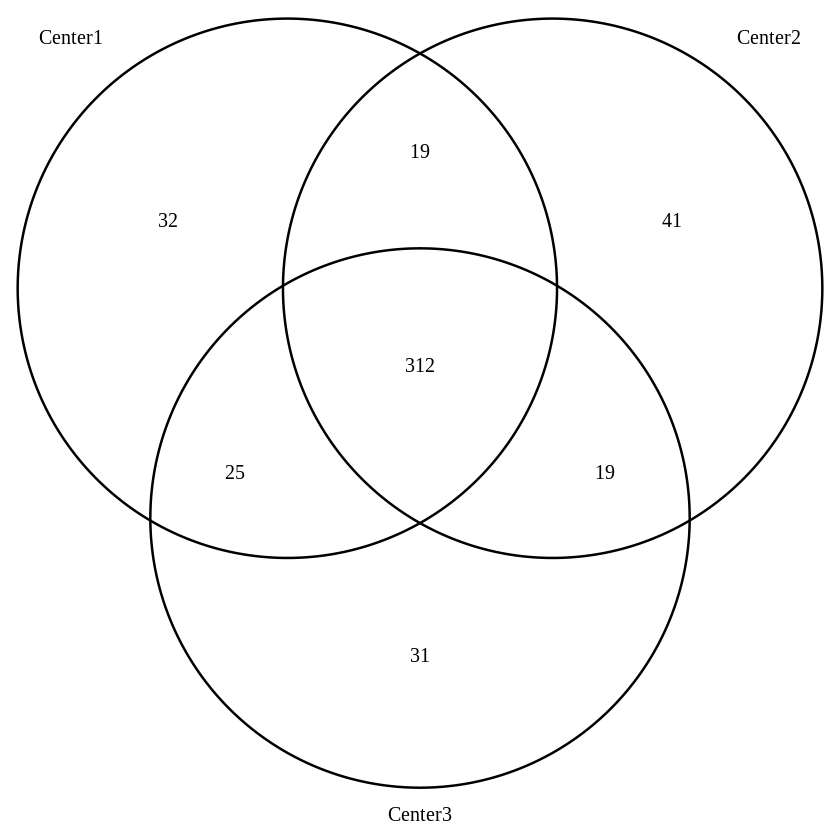

In [242]:
pg_one <- unique(combined_pg_intensities_filteres[["Center1"]]$Majority.IDs.new)
length(pg_one)

pg_two <- unique(combined_pg_intensities_filteres[["Center2"]]$Majority.IDs.new)
length(pg_two)

pg_three <- unique(combined_pg_intensities_filteres[["Center3"]]$Majority.IDs.new)
length(pg_three)

# combine all into one list
joint_proteins <- c(pg_one, pg_two, pg_three) %>% unique()
length(joint_proteins)

intersect(pg_one, pg_two) %>% intersect(pg_three) %>% length()

# plot venn  diagram
grid.newpage()

venn_plot <- venn.diagram(
    x = list(
        "Center1" = pg_one,
        "Center2" = pg_two,
        "Center3" = pg_three
    ),
    lwd = 2,
    filename = NULL)

grid.draw(venn_plot)

In [243]:
# Initialize the new data frame
result_df <- setNames(data.frame(matrix(ncol = 3, nrow = length(joint_proteins))), c("center1", "center2", "center3"))
rownames(result_df) <- joint_proteins

# Function to check intersection
check_intersection <- function(row_name, df) {
  spl_row_name <- unlist(strsplit(row_name, ";"))
  matches <- sapply(df$Majority.IDs.new, function(x) {
    length(intersect(unlist(strsplit(x, ";")), spl_row_name)) > 0
  })
  paste(df$Majority.IDs.new[matches], collapse = " | ")
}

# Fill the result data frame
for(i in 1:nrow(result_df)) {
  row_name <- rownames(result_df)[i]
  result_df[i, "center1"] <- check_intersection(row_name, combined_pg_intensities_filteres[["Center1"]])
  result_df[i, "center2"] <- check_intersection(row_name, combined_pg_intensities_filteres[["Center2"]])
  result_df[i, "center3"] <- check_intersection(row_name, combined_pg_intensities_filteres[["Center3"]])
}

In [244]:
# print rows from result_df where any of the columns contains " | " or empty string
result_df %>% filter(grepl(" | ", center1) | grepl(" | ", center2) | grepl(" | ", center3) | center1 == "" | center2 == "" | center3 == "")

,center1,center2,center3
,<chr>,<chr>,<chr>
A0A075B6P5;A0A087WW87;P01615;P01614;A2NJV5;A0A0A0MRZ7;A0A075B6S6;A0A075B6S2,A0A075B6P5;A0A087WW87;P01615;P01614;A2NJV5;A0A0A0MRZ7;A0A075B6S6;A0A075B6S2,A0A075B6P5;A0A087WW87;P01615;P01614 | A2NJV5;A0A075B6S2 | A0A0A0MRZ7;A0A075B6S6,A0A075B6P5;A0A087WW87;P01615;P01614;A0A0A0MRZ7;A0A075B6S6 | A2NJV5;A0A075B6S2
P0DP08;P0DP06;A0A0C4DH41;P01825;P06331;P01824;A0A0J9YWU9;A0A087WW49;A0A075B6R2;P0DP07;A0A087WSY4,P0DP08;P0DP06;A0A0C4DH41;P01825;P06331;P01824;A0A0J9YWU9;A0A087WW49;A0A075B6R2;P0DP07;A0A087WSY4,A0A075B6R2;A0A087WW49 | P0DP08;P0DP06;A0A0C4DH41;P01825;P06331;P01824;A0A0J9YWU9;P0DP07;A0A087WSY4,P0DP08;P0DP06;A0A0C4DH41;P01825;P06331;P01824;A0A0J9YWU9;A0A087WW49;A0A075B6R2;P0DP07;A0A087WSY4
P04908;Q96QV6;A0A0U1RR32;A0A3B3IS11;A0A0U1RRH7;C9J0D1;A0A494C189;Q96KK5;Q6FI13;P16104;Q93077;Q7L7L0;P20671;Q71UI9;Q99878;P0C0S8;Q9BTM1;Q16777;P0C0S5;C9J386,P04908;Q96QV6;A0A0U1RR32;A0A3B3IS11;A0A0U1RRH7;C9J0D1;A0A494C189;Q96KK5;Q6FI13;P16104;Q93077;Q7L7L0;P20671;Q71UI9;Q99878;P0C0S8;Q9BTM1;Q16777;P0C0S5;C9J386,P20671;Q6FI13;A0A0U1RR32;A0A0U1RRH7;Q9BTM1;P04908;P0C0S8;A0A3B3IS11;Q99878;Q7L7L0;Q93077;Q96QV6;Q16777;P16104;Q96KK5 | Q71UI9;P0C0S5;C9J0D1;A0A494C189;C9J386,P0C0S5;Q71UI9;C9J0D1;A0A494C189;C9J386;Q96QV6;A0A0U1RR32;A0A3B3IS11;A0A0U1RRH7;Q99878;Q7L7L0;P16104;P20671;Q93077;Q6FI13;P0C0S8;Q16777;Q9BTM1;Q96KK5;P04908
H0YAC1;P03952;E9PBC5,H0YAC1;P03952;E9PBC5,H0YAC1;E9PBC5 | P03952,H0YAC1;P03952;E9PBC5
P48740;F8W876,P48740;F8W876,F8W876 | P48740,F8W876 | P48740
A0A8I5KW61;P02775,A0A8I5KW61 | P02775,A0A8I5KW61;P02775,A0A8I5KW61 | P02775
P68871;A0A2R8Y7R2;F8W6P5,F8W6P5 | P68871;A0A2R8Y7R2,P68871;A0A2R8Y7R2;F8W6P5,P68871;A0A2R8Y7R2;F8W6P5;P02042
Q04756;D6RAR4,D6RAR4 | Q04756,Q04756;D6RAR4,D6RAR4 | Q04756
A0A075B6P5;A0A087WW87;P01615;P01614;A0A0A0MRZ7;A0A075B6S6,A0A075B6P5;A0A087WW87;P01615;P01614;A2NJV5;A0A0A0MRZ7;A0A075B6S6;A0A075B6S2,A0A075B6P5;A0A087WW87;P01615;P01614 | A0A0A0MRZ7;A0A075B6S6,A0A075B6P5;A0A087WW87;P01615;P01614;A0A0A0MRZ7;A0A075B6S6


## Similar using FASTA header

In [260]:

for(center in names(combined_pg_intensities)) {
    # replace the empty strings in Fasta.headers with values from Majority.protein.IDs    
    pg <- combined_pg_intensities[[center]]
    pg$Fasta.headers <- ifelse(pg$Fasta.headers == "", pg$Majority.protein.IDs, pg$Fasta.headers)
    combined_pg_intensities[[center]] <- pg
}

In [265]:
pg_one <- unique(unlist(strsplit(combined_pg_intensities[["Center1"]]$Fasta.headers, ";")))
length(pg_one)

pg_two <- unique(unlist(strsplit(combined_pg_intensities[["Center2"]]$Fasta.headers, ";")))
length(pg_two)

pg_three <- unique(unlist(strsplit(combined_pg_intensities[["Center3"]]$Fasta.headers, ";")))
length(pg_three)

common_proteins <- intersect(pg_one, pg_two) %>% intersect(pg_three) 
length(common_proteins)

[1] 539

[1] 571

[1] 497

[1] 412

In [277]:
combined_pg_intensities_filteres <- combined_pg_intensities

for(center in names(combined_pg_intensities)) {
    pg <- combined_pg_intensities[[center]]
    print(center)
    pg <- pg %>% filter(pg$Fasta.headers != "")
    print(nrow(pg))
    # pg <- pg %>% filter(Protein.IDs.common >= 0.5)
    # Create a new column that contain only proteins frim Proteins.IDs that are common
    # pg$Fasta.headers <- as.character(pg$Fasta.headers)
    pg$Fasta.headers <-sapply(pg$Fasta.headers, function(x) unique(unlist(strsplit(x, ";"))))
    # remove "" from the list
    pg$Fasta.headers <- sapply(pg$Fasta.headers, function(x) x[x != ""])  
    pg$Fasta.headers.new_list <- sapply(pg$Fasta.headers, function(x) intersect(x, common_proteins)) 
    pg$Fasta.headers.new <- pg$Fasta.headers.new_list %>%
        sapply(function(x) paste(x, collapse = ";")) %>% as.character()
    # remove rows where the new column is empty
    pg <- pg %>% filter(pg$Fasta.headers.new != "")
    combined_pg_intensities_filteres[[center]] <- pg
    print(nrow(pg))
}

[1] "Center1"
[1] 486
[1] 396
[1] "Center2"
[1] 516
[1] 397
[1] "Center3"
[1] 443
[1] 393


[1] 375

[1] 377

[1] 374

[1] 384

[1] 367

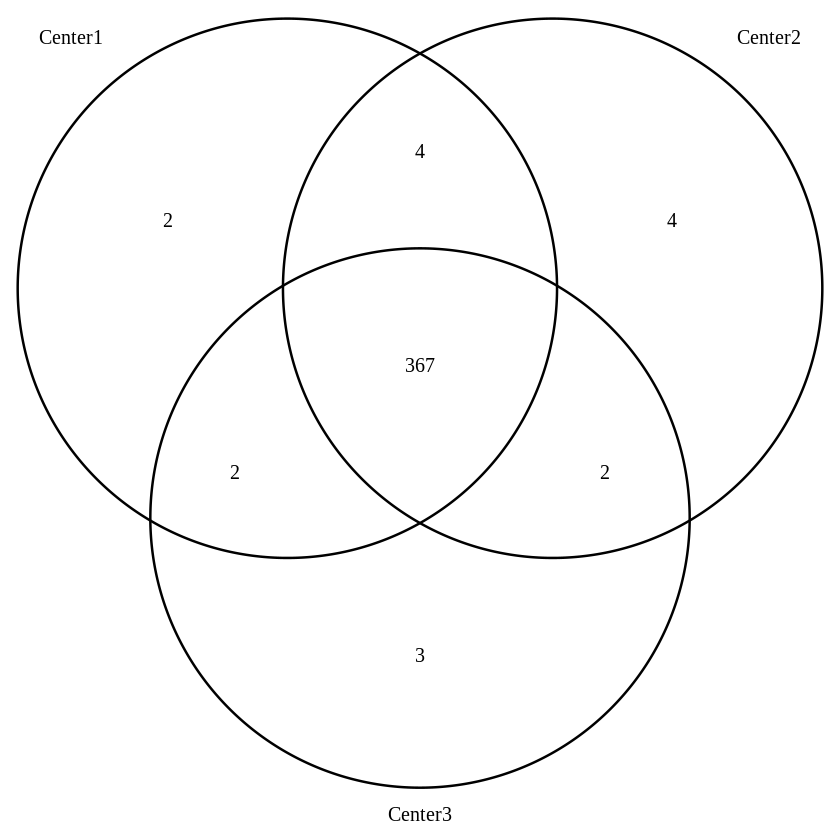

In [282]:
pg_one <- unique(combined_pg_intensities_filteres[["Center1"]]$Fasta.headers.new)
# print(length(combined_pg_intensities_filteres[["Center1"]]$Fasta.headers.new))
length(pg_one)

pg_two <- unique(combined_pg_intensities_filteres[["Center2"]]$Fasta.headers.new)
length(pg_two)

pg_three <- unique(combined_pg_intensities_filteres[["Center3"]]$Fasta.headers.new)
length(pg_three)

# combine all into one list
joint_proteins <- c(pg_one, pg_two, pg_three) %>% unique()
length(joint_proteins)

intersect(pg_one, pg_two) %>% intersect(pg_three) %>% length()

# plot venn  diagram
grid.newpage()

venn_plot <- venn.diagram(
    x = list(
        "Center1" = pg_one,
        "Center2" = pg_two,
        "Center3" = pg_three
    ),
    lwd = 2,
    filename = NULL)

grid.draw(venn_plot)

In [279]:
# Initialize the new data frame
result_df <- setNames(data.frame(matrix(ncol = 3, nrow = length(joint_proteins))), c("center1", "center2", "center3"))
rownames(result_df) <- joint_proteins

# Function to check intersection
check_intersection <- function(row_name, df) {
  spl_row_name <- unlist(strsplit(row_name, ";"))
  matches <- sapply(df$Fasta.headers.new, function(x) {
    length(intersect(unlist(strsplit(x, ";")), spl_row_name)) > 0
  })
  paste(df$Fasta.headers.new[matches], collapse = " | ")
}

# Fill the result data frame
for(i in 1:nrow(result_df)) {
  row_name <- rownames(result_df)[i]
  result_df[i, "center1"] <- check_intersection(row_name, combined_pg_intensities_filteres[["Center1"]])
  result_df[i, "center2"] <- check_intersection(row_name, combined_pg_intensities_filteres[["Center2"]])
  result_df[i, "center3"] <- check_intersection(row_name, combined_pg_intensities_filteres[["Center3"]])
}

In [280]:
# print rows from result_df where any of the columns contains " | " or empty string
result_df %>% filter(grepl(" | ", center1) | grepl(" | ", center2) | grepl(" | ", center3) | center1 == "" | center2 == "" | center3 == "")

,center1,center2,center3
,<chr>,<chr>,<chr>
IGLV3,IGLV3 | IGLV3,IGLV3 | IGLV3 | IGLV3,IGLV3 | IGLV3
IGKV2;IGKV2D,IGKV2;IGKV2D,IGKV2;IGKV2D | IGKV2;IGKV2D | IGKV2;IGKV2D,IGKV2;IGKV2D | IGKV2;IGKV2D
SAA2;SAA4,SAA2;SAA4 | SAA2,SAA2;SAA4 | SAA2,SAA2;SAA4
IGKV3D,IGKV3D | IGKV3D | IGKV3D,IGKV3D,IGKV3D | IGKV3D | IGKV3D
IGHV3,IGHV3 | IGHV3 | IGHV3;IGHV3OR16 | IGHV3 | IGHV3 | IGHV3 | IGHV3,IGHV3 | IGHV3 | IGHV3 | IGHV3 | IGHV3;IGHV3OR16,IGHV3 | IGHV3 | IGHV3;IGHV3OR16 | IGHV3 | IGHV3 | IGHV3
IGHV3;IGHV3OR16,IGHV3 | IGHV3 | IGHV3;IGHV3OR16 | IGHV3 | IGHV3 | IGHV3 | IGHV3,IGHV3OR16 | IGHV3 | IGHV3 | IGHV3 | IGHV3 | IGHV3;IGHV3OR16,IGHV3OR16 | IGHV3 | IGHV3 | IGHV3;IGHV3OR16 | IGHV3 | IGHV3 | IGHV3
IGHV4,IGHV4,IGHV4 | IGHV4,IGHV4
H2AC4;H2AC1;hCG_2039566;H2AZ2;H2AZ1;H2AC12;H2AC18;H2AX;H2AC6;H2AC25;H2AC7;H2AC14;H2AC11;H2AJ;H2AC20,H2AC4;H2AC1;hCG_2039566;H2AZ2;H2AZ1;H2AC12;H2AC18;H2AX;H2AC6;H2AC25;H2AC7;H2AC14;H2AC11;H2AJ;H2AC20,H2AC7;H2AC18;hCG_2039566;H2AJ;H2AC4;H2AC11;H2AC14;H2AC25;H2AC6;H2AC1;H2AC20;H2AX;H2AC12 | H2AZ2;H2AZ1,H2AZ1;H2AZ2;H2AC1;hCG_2039566;H2AC14;H2AC25;H2AX;H2AC7;H2AC6;H2AC18;H2AC11;H2AC20;H2AJ;H2AC12;H2AC4
ITIH4,ITIH4 | ITIH4 | ITIH4,ITIH4 | ITIH4 | ITIH4,ITIH4 | ITIH4 | ITIH4
